# Downloding the turbulent data
Data can be downloded from Johns Hopkins Turbulence Databases website. It is not possible to download a big tensor directly. Big data should be downloaded as cut-out tensors. Please visit their website: https://turbulence.pha.jhu.edu/.
The downloaded cut-out data files are in HDF5 format. The first step is converting HDF5 format to numpy format.

# Converting HDF5 format to numpy format
Small cut-out data files are named as 1.h5, 2.h5, and so on, which are splitted in X-direction. Then, the following code loops over the files and converts them to numpy format and saves them.

In [1]:
import h5py
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

os.chdir('/home/ht/JH/4096')


# Define the directory where your files are located
directory = '/home/ht/JH/4096/'

# Use glob to find all files with the pattern '*.h5' in the specified directory
file_paths = glob.glob(f'{directory}/*.h5')

# Iterate over the list of file paths
for file_path in file_paths:
    # Extract the file number from the file name
    file_number = file_path.split('/')[-1].split('.')[0]
    # Open the HDF5 file in read-only mode
    with h5py.File(file_path, 'r') as file:
        # Access the dataset within the HDF5 file
        dataset = file['Velocity_0001']
        # Convert the dataset to a NumPy array
        numpy_array = np.array(dataset)

    # Save the NumPy array to a corresponding .npy file
    np.save(f'{file_number}.npy', numpy_array)

# Concatenating data
The small cut-out data files are concatenated to a big numpy tensor.

In [2]:
# Number of files
num_arrays = 33

# Initialize the first array outside the loop
velocity = np.load('1.npy')

# Concatenate the arrays inside the loop
for i in range(2, num_arrays + 1):
    file_name = f'{i}.npy'
    numpy_array = np.load(file_name)
    velocity = np.concatenate((velocity, numpy_array), axis=2)

np.save('velocity.npy', velocity)
print("tensor size: ",velocity.shape)

tensor size:  (1032, 1032, 1032, 3)


# plotting a slice of the big tensor

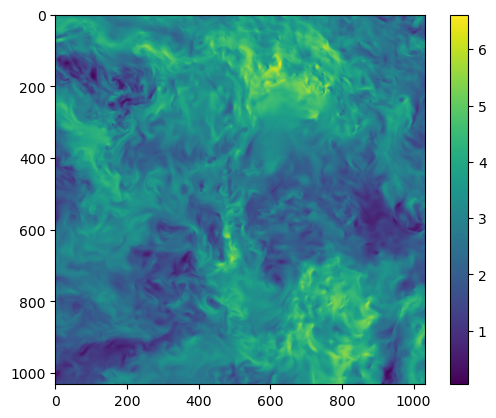

In [3]:
slice_data = np.linalg.norm(velocity[:, 0, :, :], axis=(2))

plt.imshow(slice_data)
plt.colorbar()
plt.savefig('your_image.png', dpi=1000, bbox_inches='tight', pad_inches=0.1)

# Tensor spiltting into sub-boxes
For training a SRGAN we need to split the data to several sub-boxes with the resolution of 64^3.

### Loading the essential libs

In [4]:
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Loading the data
This is downloaded from Johns Hopkins Turbulence Databases (JHTDB): https://turbulence.pha.jhu.edu/Forced_isotropic_turbulence.aspx

In [5]:
os.chdir('/home/ht/JH/4096')
velocity = np.load('velocity.npy')

### Cyclic boundary padding
Four layers of cells are considered in each direction for cyclic padding.

In [6]:
velocity = np.transpose(velocity, (3, 0, 1, 2))
velocity = torch.from_numpy(velocity).unsqueeze(0)
#we have downloaded a tensor with the size of 1024 from the 4096 dataset incluing padding cells, so we do not need cycling padding!
#velocity = F.pad(velocity,(4, 4, 4, 4, 4, 4) ,mode='circular')
velocity = velocity.numpy()

### Splitting and writing
After splitting, the data in sub-boxes is not accessible from neighboring sub-boxes. That is why we need to consider padding during splitting.

In [7]:
output_dir = "./sub_boxes"
os.makedirs(output_dir, exist_ok=True)

for i in range(0, 1024, 64):
    for j in range(0, 1024, 64):
        for k in range(0, 1024, 64):
            # Extract the sub box including padding part
            sub_box_padded_64 = velocity[:, :, i:4+i+64+4, j:4+j+64+4, k:4+k+64+4]
            filename = f"sub_field_{i}_{j}_{k}.npy"
            np.save(os.path.join(output_dir, filename), sub_box_padded_64)

### Loading and plotting a sub-box as an example

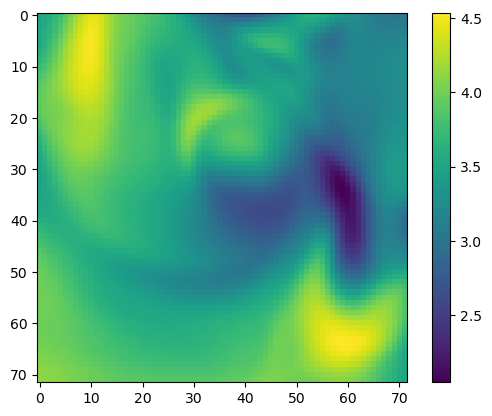

In [9]:
sub_box_padded_64 = np.load('./sub_boxes/sub_field_0_832_896.npy')
sub_box_padded_64=sub_box_padded_64[0]
slice_data = np.linalg.norm(sub_box_padded_64[:, 44, :, :], axis=(0))

plt.imshow(slice_data)
plt.colorbar()
plt.savefig('your_image.png', dpi=1000, bbox_inches='tight', pad_inches=0.1)